In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
/*Disable scrollbar in a cell*/

<IPython.core.display.Javascript object>

In [2]:
from custom_functions import *

# import matplotlib as mpl
# print(mpl.rcParams.keys())
sns.set(style="whitegrid", font_scale=1.6)
plt.style.use('paper.mplstyle.txt')
markers = ('o', 'v', 's', 'd', '<', '+')

C:\Users\edignum\.virtualenvs\compassproject-OUBZ_QZN\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
# Load data
name = 'amsterdam-q1q5'
path_to_frame = f'../experiments/{name}/'
frame = pd.read_pickle(f"{path_to_frame}{name}.pkl")
segregation_data = pd.read_pickle(f"{path_to_frame}data/frame.pkl")
plot_path = f'../plots/{name}'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

# Format data
# Construct a dictionary of name (key) and title for plots (value)
names_bounds = {'single_utility_at_max': 'Utility at homogeneity (M)',
                'single_optimal_fraction': 'Optimal fraction ($t_i$)', 
                'alpha': 'Alpha',
                'dist_threshold':'Distance threshold (m)',
                'school_capacity': 'School capacity (c)',
                'random_residential': 'Random residential'}

var_params = {'single_utility_at_max': [0, 0.2, 0.4, 0.6, 0.8, 1],
            'single_optimal_fraction': [0.4, 0.45, 0.5, 0.55, 
                                            0.6, 0.65, 0.7, 0.75, 0.8],
            'alpha':[0, 0.2, 0.4, 0.6, 0.8, 1],
            'dist_threshold':[0, 2000, 4000, 6000, 8000, 50000],
            'random_residential':[0, 1],
             }
nominal_values = {'single_utility_at_max':0.6,
                'single_optimal_fraction':0.5,
                'alpha':0.2,
                'dist_threshold':4000,
                'random_residential':0
                 }

# Construct lists of input columns and outputs to plot
columns_to_plot = list(names_bounds.values())
outcomes = {
            'residential_own_entropy': 'Residential segregation (Theil)',
            'residential_dissim': 'Residential segregation (Dissimilarity)',
            'school_own_entropy': 'School segregation (Theil)',
            'school_dissim': 'School segregation (Dissimilarity)',
            }
outcomes_to_plot = list(outcomes.values())

# Rename the columns
segregation_data.rename(columns=names_bounds, inplace=True)
segregation_data.rename(columns=outcomes, inplace=True)
if 'res_seg' in segregation_data.columns:
    segregation_data.drop(['res_seg', 'school_seg'], axis=1, inplace=True)
    
# print(segregation_data[['res_converged', 'school_converged']].describe())

# Load agents

In [4]:
# filename = "../compass/maps//agents_amsterdam_ethnicity.pickle"
filename = "../compass/maps/agents_amsterdam_q1q5_dist.pickle"
with open(filename, "rb") as f:
    data = pickle.load(f)

# More agents are simulated to sample from them and incorporate some 
# randomness in the type and spatial distribution
perc_of_actual = data['perc_of_actual']
total_households = len(data['households'])
actual_households = int(total_households / perc_of_actual)
print(total_households, actual_households)

40159 33465


In [5]:
rows, points, categories = [], [], []
count = 0
for household in data['households']:
    point, category = extract_data(household)
    categories.append(category)
    distances = household.distances
    points.append(Point(point))
    rows.append(list(distances.values())[:-2])
    
np_distances = np.array(rows)

iters = 10
kind = 'Theil'
max_alpha = 5
metrics = []
par_values = []
groups = np.array([(categories==group).astype(int) for group in np.unique(categories)])
plot_data = pd.DataFrame(columns=['Alpha', 'School segregation'])

ind_closest = np_distances.argmin(axis=1)
for alpha in tqdm(range(max_alpha+1)):
    probabilities = choice_set(np_distances, alpha, ind_closest)
    par_values += list(np.repeat(alpha, iters))
    allocations = np.array([allocate(groups, probabilities, 
                                     actual_households, total_households) for _ in range(iters)])
    metrics += [calculate_segregation(allocation.T, kind) for allocation in allocations]

plot_data['Alpha'] = par_values
plot_data['School segregation'] = metrics

means = []
sorted_schools = np.argpartition(np_distances, kth=list(range(np_distances.shape[1])), axis=1)
for n in tqdm([1, 5, sorted_schools.shape[1]]):
    
    probs = np.zeros(np_distances.shape)
    np.put_along_axis(probs, sorted_schools[:,:n], 1, axis=1)
    normed_probs = probs / probs.sum(axis=1)[:,None]
    
    allocations = np.array([allocate(groups, normed_probs,
                                    actual_households, total_households) for _ in range(iters)])
    par_values += [n]*iters
    segregation = [calculate_segregation(allocation.T, kind) for allocation in allocations]
    means += [segregation]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.80s/it]


# OFAT

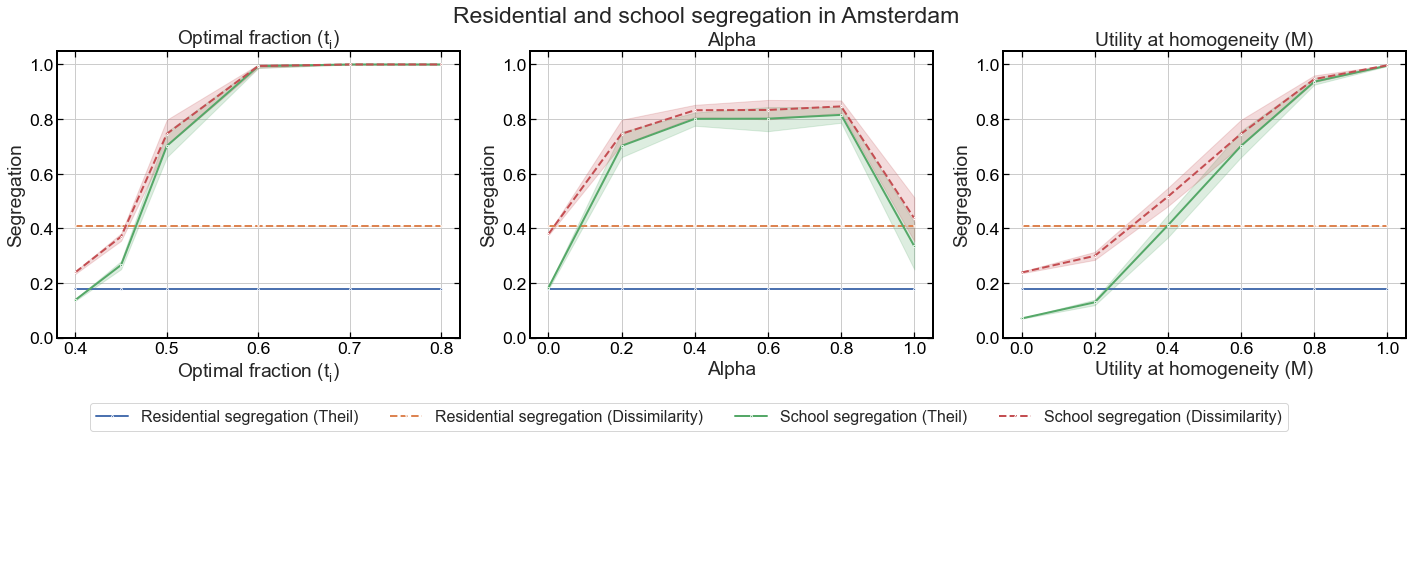

In [6]:
n_rows=2
n_cols=3
figsize=(20,10)
fig = plt.figure(figsize=figsize)
data = segregation_data.copy()
subset = {names_bounds[name]:var_params[name] for name in ['single_optimal_fraction',
            'alpha', 'single_utility_at_max']}

for i, var in enumerate(subset):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    
    var_range = subset[var]
    temp_data = data[data[var].isin(var_range)]
    
    for name, value in nominal_values.items():
        if names_bounds[name] != var:
            temp_data = temp_data[temp_data[names_bounds[name]]==value]
    
    for index, outcome in enumerate(outcomes_to_plot):
        x = temp_data[var]
        y = temp_data[outcome]
        sns.lineplot(x=x, y=y, ax=ax, marker=markers[index], ci=95)
    
    ax.lines[1].set_linestyle("dashed")
    ax.lines[3].set_linestyle("dashed")
    
    ax.set_title(var)
    ax.set_ylabel('Segregation')
    plt.ylim(0, 1.05)
    
fig.legend(outcomes_to_plot, fontsize=16, bbox_to_anchor=(0.90, 0.25), ncol=4)
fig.tight_layout()
# plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.suptitle('Residential and school segregation in Amsterdam')
plt.tight_layout(rect=[0, 0, 1, 0.98])
save_figure(plot_path, filename='ofat')
plt.show()

# With and without residential segregation

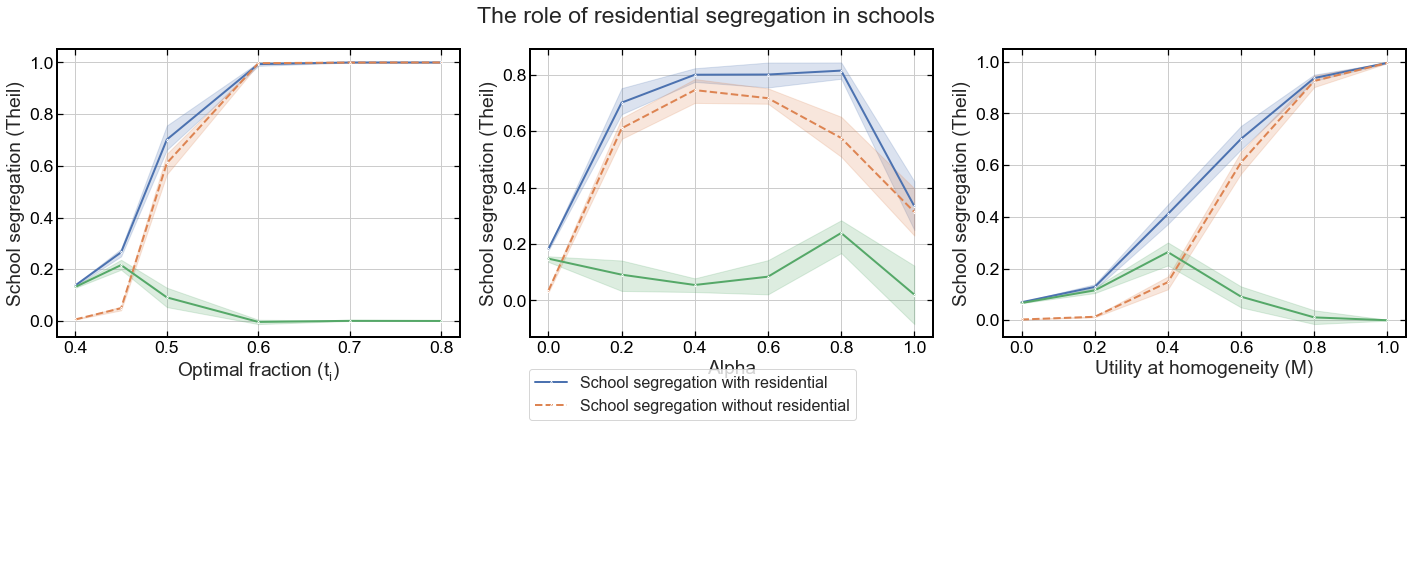

In [7]:
data = segregation_data.copy()
subset = {names_bounds[name]:var_params[name] for name in ['single_optimal_fraction',
            'alpha', 'single_utility_at_max']}

n_rows=2
n_cols=3
figsize=(20,10)
fig = plt.figure(figsize=figsize)
    
for i, var in enumerate(subset):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    
    var_range = subset[var]
    temp_data = data[data[var].isin(var_range)]
    
    for name, value in nominal_values.items():
        if name=='random_residential':
            no_res_steps = temp_data[temp_data[names_bounds[name]]==1]
        
        if names_bounds[name] != var:
            temp_data = temp_data[temp_data[names_bounds[name]]==value]
    
#     # Counterfactual
#     sns.lineplot(x=temp_data[var], 
#                  y=temp_data['Residential Segregation (Theil)'], 
#                  ax=ax, marker=markers[index], ci=95)
    
    # School segregation with
    sns.lineplot(x=temp_data[var], 
                 y=temp_data['School segregation (Theil)'], 
                 ax=ax, marker=markers[index], ci=95)
    
    # School segregation without
    sns.lineplot(x=no_res_steps[var], 
                 y=no_res_steps['School segregation (Theil)'], 
                 ax=ax, marker=markers[index], ci=95)
    
    # The effect of residential
#     print(temp_data['School Segregation (Theil)'])
#     print()
#     print(no_res_steps['School Segregation (Theil)'])
#     raise ValueError
#     sns.lineplot(x=no_res_steps[var], 
#                  y=temp_data['School Segregation (Theil)'].values - \
#                  no_res_steps['School Segregation (Theil)'].values, 
#                  ax=ax, marker=markers[index], ci=95)
    
    y_sim = temp_data.sort_values(by=[var])
    y_sim_no_res = no_res_steps.sort_values(by=[var])
    x = y_sim[var]
    y = y_sim['School segregation (Theil)'].values - y_sim_no_res['School segregation (Theil)'].values
    sns.lineplot(x=x, y=y, ax=ax, marker=markers[index], ci=95)
    ax.lines[1].set_linestyle("--")
    
    ax.set_ylabel('School segregation (Theil)')
#     plt.ylim(-0.1, 1.05)

fig.legend(('School segregation with residential',
            'School segregation without residential'),
           fontsize=16, bbox_to_anchor=(0.6, 0.29))
fig.tight_layout()
plt.suptitle('The role of residential segregation in schools')
plt.tight_layout(rect=[0, 0, 1, 0.95])
save_figure(plot_path, filename='residential-role')
plt.show()

# The effect of residential segregation in schools

C:\Users\edignum\AppData\Local\Temp\ipykernel_31532\2783497535.py:72: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()
C:\Users\edignum\AppData\Local\Temp\ipykernel_31532\2783497535.py:74: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0, 0, 1, 0.85])


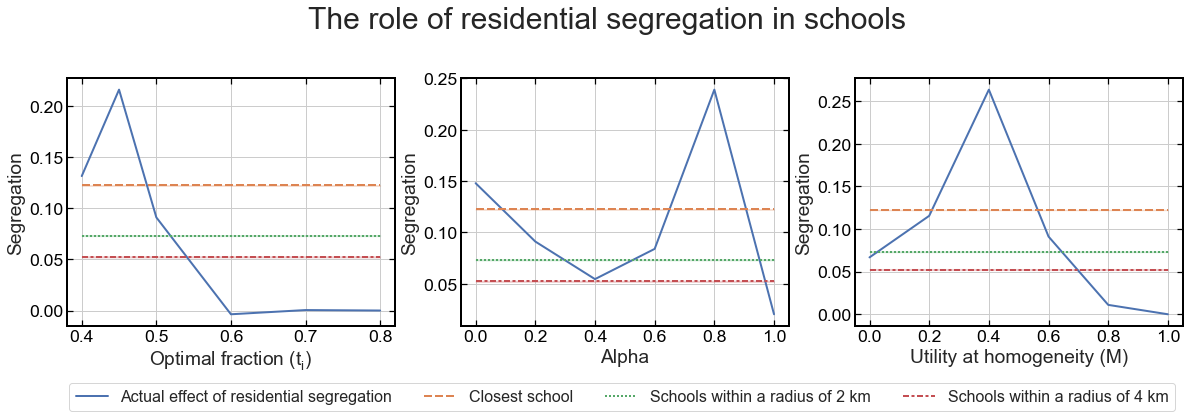

In [8]:
data = segregation_data.copy()
subset = {names_bounds[name]:var_params[name] for name in ['single_optimal_fraction',
            'alpha', 'single_utility_at_max']}

n_rows=2
n_cols=3
figsize=(20,10)
fig = plt.figure(figsize=figsize)

ls = ['-','--',':','-.','-','--',':','-.','-','--',':','-.',
      '-','--',':','-.','-','--',':','-.','-','--',':','-.']
colors = sns.color_palette()
    
for i, var in enumerate(subset):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    
    var_range = subset[var]
    temp_data = data[data[var].isin(var_range)]
    
    for name, value in nominal_values.items():
        if name=='random_residential':
            no_res_steps = temp_data[temp_data[names_bounds[name]]==1]
        
        if names_bounds[name] != var:
            temp_data = temp_data[temp_data[names_bounds[name]]==value]
    
    xs = []
    ys = []
    measures = []
    
    
    y_sim = temp_data.sort_values(by=[var])
    y_sim_no_res = no_res_steps.sort_values(by=[var])
    x = y_sim[var].unique()
    y = y_sim.groupby(var).mean()['School segregation (Theil)'].values - \
        y_sim_no_res.groupby(var).mean()['School segregation (Theil)'].values
#     ax = sns.lineplot(x=x, y=y, color=colors[0], markers=markers[0], ax=ax, ci=95)
    
    xs += list(x)
    ys += list(y)
    measures += ['Actual effect of residential segregation']*len(x)
    
    radiuses = [0, 2, 4]
    for index, radius in enumerate([0, 2, 4]):
        y = plot_data[plot_data['Alpha']==radius]['School segregation']
        x = np.array([[var]*len(y) for var in y_sim[var].unique()]).flatten()
        y_rep = np.array([[y] for var in y_sim[var].unique()]).flatten()
#         ax = sns.lineplot(x=x, y=y_rep, ax=ax, color=colors[index+1],
#                       linestyle=ls[index+1], markers=markers[index+1])
        xs += list(x)
        ys += list(y_rep)
        if radius==0:
            label = 'Closest school'
        else:
            label ='Schools within a radius of ' + str(radius) + ' km'
        
        measures += [label]*len(x)
        
    plot_frame = pd.DataFrame()
    plot_frame[var] = xs
    plot_frame['Segregation'] = ys
    plot_frame['Measure'] = measures
    
    if i==2:
        legend=True
    else: legend=False
    ax = sns.lineplot(data=plot_frame, x=var, y='Segregation', 
                    hue='Measure', style='Measure', ax=ax, legend=False)           

# h, l = ax.get_legend_handles_labels()
plt.legend(labels=np.unique(measures), fontsize=16, bbox_to_anchor=(1, -0.2), ncol=4)
fig.tight_layout()
plt.suptitle('The role of residential segregation in schools', fontsize=30)
plt.tight_layout(rect=[0, 0, 1, 0.85])
save_figure(plot_path, filename='residential-role')
plt.show()